# Word2Vec
This time we'll do word prediction using word2vec approach 
## Data
Data is taken form recent Kaggle Toxic comment competition. Fields of CSV file are
<ul>
    <li>Source Address (IP/url or Ethernet/Physical)</li>
    <li> Comment</li>
</ul>
In addition in training file one hot encoding of classification type, total 6 types: 
<ul>
    <li>"toxic",</li>
    <li>"severe_toxic",</li>
    <li>"obscene", </li>
    <li>"threat",</li>
    <li>"insult",</li>
    <li>"identity_hate"</li>
</ul>
One hot means that to every type correspond a field (column) of the input and each comment/row has 1 in one of these fields (i.e. in the filed corresponding to the type associated to it) and 0 in all others.
## Packages
NLTK- natural language tool kit library that allows to process text.
<ul>
    <li>Tokenization: given a comment treated as a sequence of words, we need to chop it up into pieces, called tokens (words possibly with drop of some parts).</li>
    <li>Tokenizer is used in conjuction with string operations that throw away certain characters, such as punctuation and prefix/suffix. </li>
    <li>Tokenizer also usually needs a same case words so we need operation that convert to lowercase all text</li>
    <li> Tokenization creates bag of words model. If we take into account window size and embedding into $\mathbb{R}^𝑛$ this will be CBOW model</li>
</ul>    

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer

nltk.tokenize has dependency on sqllite3 that needs to be loaded. If it does not load automatically then it needs to be loaded manually: 
<ol>
    <li>download the sqllite3 dll binary from https://www.sqlite.org/download.html. Use appropriate binary for your system and your computer.</li> 
    <li>unzip dll and put it into 2 directories one is where anaconda dll's are - in my case it is  C:\Users\YOURUSERName\Anaconda3\DLLs and into a folder where your environment is. 
    <li> To find out where it is run from terminal >conda info --envs it will give you the environment folder. In my case C:\Users\YOURUSERname\Anaconda3\envs\</li>
</ol>

Also we need the following additional packages that are standard to python:
<ol>
    <li>regex
        <ul>
            <li> It allows to write regular expressions that then are matched using functions findall, replace, search, split. 
Expressions are written using special symbols (e.g  sub$ - everything that ends with sub before CR) that allow for repetitions. See  https://docs.python.org/3/library/re.html for symbols. It also loads data and parses it (see the below)</li>
        </ul>
    </li>
    <li>string
    <uL>
       <li> functions that remove punctuation and converts to lowercase
    </ul></li>
    <li>counter
    <ul>
        <li> Counter is a container that keeps track of how many times equivalent values are added. It is used to implement bag/multiset data structures.</li>
        </ul></li>
    <li>tqdm
    <ul>
    <li>allows to show progress, and predicts the remaining time as you move over the task</li>
    </ul>
    </li>
<ol>

In [2]:
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

## Input data
As usual check if we are in Google colab or working locally

In [3]:
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

Set the path to the directory into which the original dataset is located. New Python twist: I assume that data is located in a subdirectory of a directory from which we launched the program.I also assume that comments are already split into 'train.csv' file and 'test.csv' that are located in this subdirectory

In [4]:
if not IN_COLAB:
#    dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
    dir_path = os.getcwd()
    data_dir = os.path.join(dir_path, 'Data/ToxicComment')
else:
    drive.mount('/content/gdrive')
    dir_path = os.path.dirname(os.path.realpath(os.path.abspath('')))
    data_dir = os.path.join(dir_path, '/content/gdrive/My Drive/courses/Deep Learning/data/ToxicComment')
if not os.path.exists(data_dir):
    exit(3)
else:
    TRAIN_DATA_FILE=os.path.join(data_dir,'train.csv')
    TEST_DATA_FILE=os.path.join(data_dir,'test.csv')
    train_df = pd.read_csv(TRAIN_DATA_FILE)
    test_df = pd.read_csv(TEST_DATA_FILE)
    print(train_df.head(10))

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0          

## Data Preprocessing
Compile expressions to replace urls and ip addresses. These are irrelevant for classification so we replace these. In particular re.compile compiles a regular expression pattern into a regular expression object, which can be used for matching using its match(), search() and other methods. So what it says here that url is a raw expression that begins with "http" or "https" next must come ":" and "//" where "?at the end is a symbol that allows either 0 or 1 occurence of last symbol (so it could be either "/" or "//"), then alpha numeric text up to a ".", etc. I didn't invent this expression this is well-known expression that I took from https://www.codegrepper.com/code-examples/python/match+url+regex+python. Same for ip adress https://stackoverflow.com/questions/19435366/python-regex-logic-for-matching-ip-addresses   

In [5]:
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE | re.UNICODE)
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

setup tokenizer and word counter

In [6]:
tokenizer = WordPunctTokenizer()
vocab = Counter()

In the next function I remove url substituting it by word "url" and "ipaddress" by word "ipaddress", tokenize text and convert it to lowercase (if corresponding argument is given). the counter for the new token that was just created is given. Function x.sub(y,text) matches occuresnce of x in the text and subbs this occurence with word y. Function tokenizer.tokenize(x) splits the text x into bag of words removing punctuations (this is what word.punct toknizer does) and returns the list of separate words. The x.update(list) for x counter takes the list and converts it to a dictionary in which each word occurs exactly once (second occurence is ignored). In other words a word is the value in this dictionary and its number (in the order of occurences) is the key.

In [7]:
def text_to_wordlist(text, lower=False):
    text = re_url.sub("URL", text)
    text = re_ip.sub("IPADDRESS", text)
    text = tokenizer.tokenize(text)
    if lower:
        text = [t.lower() for t in text]
    vocab.update(text)
    return text

The netx function is essentially an envelope that allows to show progress by showing progress moving through separate comments.
Each comment is tokenized and appended to comments that are returned as one ‘long sentence’ of words

In [8]:
def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

Now remove from the input entries for which value of comment_text column are not defined (NAN_WORD)). Do that for test and for train sequences. Then using described functions process_comments and text_toword list convert every both training and testing comments into one dictionary of tokens that contains words with numbers of their occurences 

In [9]:
list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)
print("The vocabulary contains {} unique tokens".format(len(vocab)))

100%|███████████████████████████████████████████████████████████████████████| 312735/312735 [00:15<00:00, 20145.25it/s]

The vocabulary contains 365516 unique tokens


We use Gensim is a library for unsupervised topic modeling and natural language processing. It has implemented word2vec layer that I use/import here. The argumnets of the layer are:
<ul>
    <li>Our input is in comments</Li>
    <li>The size is the number of output channels (neurons) = dimesionality of output vector. As always wider NN is, more training data it requires, longer is the training </li>
    <li> Window is the maximum distance between the current and predicted word within a sentence. For example when window is 5 and our word is number 7, then we'll take window words on the left and window words on the right of our target - (2,6) and (8,12)</li>
    <li>Min_count is for ignoring all words with total frequency lower than this.</li>
    <li>Workers, number of simultaneous threads run (as much as I have processors on my computer)</li>
    <li>Sg – choice of algorithms (1-skipgram, 0- CBOW)</li>
    <li>Negative – how many negative words for sampling will be drawn(so that output won’t be of dim d)</li>
</ul>
So I set up the w2v layer and I then train this layer on my text and save vectors: 

    - word_vectors = model.wv
This command returns dictionary of vectors of words with the key to the vector being the word itself. I then print cosine similarity model.wv.most_similar_cosmul between words on vetors that we computed (i.e. normalized dot product between these vectors) and print it out.

In [10]:
from gensim.models import Word2Vec
model = Word2Vec(comments, size=100, window=5, min_count=5, workers=16, sg=0, negative=5)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))
print(model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man']))

Number of word vectors: 70056
[('prince', 0.9865513443946838), ('queen', 0.9859681725502014), ('princess', 0.9757775664329529), ('bishop', 0.9443601369857788), ('mary', 0.9398441910743713), ('duchess', 0.9262488484382629), ('scotland', 0.9131278991699219), ('elizabeth', 0.9131265878677368), ('emperor', 0.9101772904396057), ('pope', 0.9052255749702454)]


Set up the maximum length of the sequence (i.e. for comment to be analyzed its max length is set to 200) and the total number of vectorized words that is all words we vectorized. We then take vocabulary (dictionary \<word, number of occurences)\>) to direct word index (dictionary \<word, its number in the order of occurences in vocabulary\>). And the convert comments into sequence of words into sequence of numbers (actually list of numbers) where each word is subsituted by its number in the word index. Thus the set of all train sequences (trraining comments) are going to be the list of lists of numbers. The Pad_sequences function transforms a list of sequences (i.e. list of lists of integers) into a 2D Numpy array of shape (number of lists, maxlen). Pad before conversion if shorter, truncate after conversion if longer. I do conversion for both training data and testing data.

In [11]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment]
                  for comment in comments[len(list_sentences_train):]]

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,
                     padding="pre", truncating="post")

Using TensorFlow backend.


Then I create a list of exiting classes in training sequences, and I pull out of training data frame a 2D array of true values of one hot encoded classes. So y vector is now the hot encoded cllassification vector for training data. Finally I print shapes of the data and classification array.

In [12]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


I now pad test sequences

In [13]:
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of test_data tensor: (153164, 200)


I initialize the matrix with random numbers.

In [14]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))+1
print(nb_words)
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

70057


Lookup a word in the index of words. If the word number is less than the total number of vectorized words, t n it would be found in the index if it has enough occurences, and then we retrieve its vectors and set corresponding row of matrix to this vector. 
If a word was not found then in index (small number of occurences) then its row will be passed, i.e. be random as it was inititalized

In [15]:
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        wv_matrix[i] = embedding_vector
    except:
        pass

In embedding layer each value in the input_array each input integer is used as the index to access a table that contains all posible vectors - that is weights vector of our wv matrix. That is the reason why you need to specify the size of the vocabulary as the first argument.
Layer arguments are:
<ul>
    <li>Size of the vocabulary, i.e. maximum integer index + 1 (nb_words that we defined)</li>
    <li>Dimension of the embedding</li>
<li>Mask_zero is  whether or not the input value 0 is a special "padding" value that should be masked out; not in our case</li>
</ul>
This layer is non-trainable – we already computed vectorization. It is given as weights matrix!

In [16]:
from keras.layers import Embedding
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

The network model is standard shallow except the first layer is embedding that we already defined. Middle layer is dense with 32 relu neurons and output layer is softmax classifying in 6 classes so loss is crossnetropy which is standard for softmax
Backpropagation is rmsprop (later). Metric that we are looking at is accuracy  

In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(wv_layer)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          7005700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 7,645,930
Trainable params: 640,230
Non-trainable params: 7,005,700
_________________________________________________________________


Train on our data (list of lists of numbers representing words) taking 0.1 of all lists for validation, prepared list of true classes, with standard batch size. Record history object for plotting

In [19]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
#loss='categorical_crossentropy',
metrics=['acc'])
history = model.fit([data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 11s 75us/step - loss: 0.2205 - acc: 0.9667 - val_loss: 0.2302 - val_acc: 0.9638
Epoch 2/10
143613/143613 [==============================] - 10s 71us/step - loss: 0.2203 - acc: 0.9668 - val_loss: 0.2305 - val_acc: 0.9634
Epoch 3/10
143613/143613 [==============================] - 10s 68us/step - loss: 0.2201 - acc: 0.9668 - val_loss: 0.2303 - val_acc: 0.9638
Epoch 4/10
143613/143613 [==============================] - 10s 66us/step - loss: 0.2200 - acc: 0.9669 - val_loss: 0.2301 - val_acc: 0.9636
Epoch 5/10
143613/143613 [==============================] - 10s 70us/step - loss: 0.2198 - acc: 0.9669 - val_loss: 0.2311 - val_acc: 0.9632
Epoch 6/10
143613/143613 [==============================] - 10s 72us/step - loss: 0.2197 - acc: 0.9671 - val_loss: 0.2309 - val_acc: 0.9637
Epoch 7/10
143613/143613 [==============================] - 11s 75us/step - loss: 0.2196 - acc: 0.9671 - val_

In [22]:
history_dict = history.history
print(history_dict.keys())
history = pd.DataFrame(history.history)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


I set up ggplot style that is standard for many pythong and R plotting procedures - gives better graphics. Plot as usual except this time I decided to save it into a file so needed to create a path to it

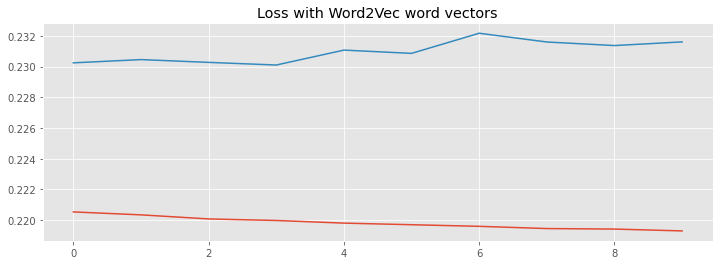

<Figure size 432x288 with 0 Axes>

In [29]:
plt.style.use("ggplot")
plt.figure(figsize=(12,4))
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss with Word2Vec word vectors")
plt.show()
file_save = os.path.join(dir_path, 'Data/ToxicComment/plot.png')
plt.savefig(file_save)

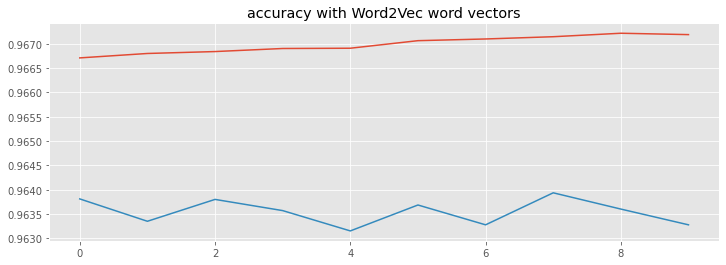

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(12,4))
plt.plot(history["acc"])
plt.plot(history["val_acc"])
plt.title("accuracy with Word2Vec word vectors")
plt.show()

Next to predict. Prediction on test data returns probabilities of all 6 classes as a separate numpy array so need to convert to dataframe with correct names of colums. Then I find the name of the column with maximum value (type.idxmax(axis=1), and put this name into a new data frame with one column named ‘class’. Then merge the original test data frame with ‘class’ data frame and save it. 

In [30]:
type = model.predict([test_data])
type = pd.DataFrame(type,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
type1=pd.DataFrame(type.idxmax(axis=1),columns=['class'])
test_ndf =pd.concat([test_df, type1], axis=1)
df_save = os.path.join(dir_path, 'Data/ToxicComment/text_classified.csv')
test_ndf.to_csv(df_save, index=False)